In [7]:
import os
import re
from collections import Counter
from string import punctuation

import numpy as np
import tensorflow as tf
from keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.models import Sequential, save_model
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot
from pandas import Series, read_csv, read_json, read_pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
from nltk import WordNetLemmatizer, pos_tag

In [2]:
nltk.download("averaged_perceptron_tagger", download_dir="nltk")
nltk.download("wordnet", download_dir="nltk")
nltk.download("omw-1.4", download_dir="nltk")
nltk.download("stopwords", download_dir="nltk")
nltk.download("punkt", download_dir="nltk")
nltk.data.path.append(os.path.abspath("nltk"))

[nltk_data] Downloading package averaged_perceptron_tagger to nltk...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to nltk...
[nltk_data] Downloading package omw-1.4 to nltk...
[nltk_data] Downloading package stopwords to nltk...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to nltk...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
RANDOM_SEED = 1


def clean_text(doc: str) -> list[str]:
    """A function that cleans a given text document"""
    stop_words = set(stopwords.words("english")) - {"not", "no"}
    lemmatizer = WordNetLemmatizer()

    doc = doc.lower()
    doc = doc.replace("n't", " not ")
    doc = re.sub(r"(?:\'ll |\'re |\'d |\'ve)", " ", doc)
    doc = re.sub(r"/d+", "", doc)

    tokens = [
        word
        for word in word_tokenize(doc)
        if word not in stop_words and word not in punctuation
    ]

    pos_tags = pos_tag(tokens)
    cleaned_text = [
        (
            lemmatizer.lemmatize(word, part_of_speech[0].lower())
            if part_of_speech[0] in "NV"
            else word
        )
        for word, part_of_speech in pos_tags
    ]

    return cleaned_text


def split_data(features: Series, targets: Series, train_fraction: float = 0.8):
    """Splits a given dataset into training, validation and test sets"""
    # Separate indices of negative and positive data points
    neg_indices = Series(targets.loc[(targets == 0)].index)
    pos_indices = Series(targets.loc[(targets == 1)].index)

    n_test = int(
        min([len(neg_indices), len(pos_indices)]) * ((1 - train_fraction) / 2.0)
    )

    neg_test_inds = neg_indices.sample(n=n_test, random_state=RANDOM_SEED)
    neg_valid_inds = neg_indices.loc[~neg_indices.isin(neg_test_inds)].sample(
        n=n_test, random_state=RANDOM_SEED
    )
    neg_train_inds = neg_indices.loc[
        ~neg_indices.isin(neg_test_inds.tolist() + neg_valid_inds.tolist())
    ]

    pos_test_inds = pos_indices.sample(n=n_test, random_state=RANDOM_SEED)
    pos_valid_inds = pos_indices.loc[~pos_indices.isin(pos_test_inds)].sample(
        n=n_test, random_state=RANDOM_SEED
    )
    pos_train_inds = pos_indices.loc[
        ~pos_indices.isin(pos_test_inds.tolist() + pos_valid_inds.tolist())
    ]

    train_features = features.loc[
        neg_train_inds.tolist() + pos_train_inds.tolist()
    ].sample(frac=1.0, random_state=RANDOM_SEED)
    train_target = targets.loc[
        neg_train_inds.tolist() + pos_train_inds.tolist()
    ].sample(frac=1.0, random_state=RANDOM_SEED)

    valid_features = features.loc[
        neg_valid_inds.tolist() + pos_valid_inds.tolist()
    ].sample(frac=1.0, random_state=RANDOM_SEED)
    valid_targets = targets.loc[
        neg_valid_inds.tolist() + pos_valid_inds.tolist()
    ].sample(frac=1.0, random_state=RANDOM_SEED)

    test_features = features.loc[
        neg_test_inds.tolist() + pos_test_inds.tolist()
    ].sample(frac=1.0, random_state=RANDOM_SEED)
    test_targets = targets.loc[neg_test_inds.tolist() + pos_test_inds.tolist()].sample(
        frac=1.0, random_state=RANDOM_SEED
    )

    print(f"Training data: {len(train_features)}")
    print(f"Validation data: {len(valid_features)}")
    print(f"Test data: {len(test_features)}")

    return (
        (train_features, train_target),
        (valid_features, valid_targets),
        (test_features, test_targets),
    )


def get_pipeline(
    text_seq: list[list[int]],
    outputs: Series,
    batch_size: int = 64,
    bucket_boundaries: list[int] = [5, 15],
    max_length: int = 50,
    shuffle: bool = False,
):
    """Data pipeline that converts sequences to batches of data"""
    data_seq = [[b] + a for a, b in zip(text_seq, outputs)]
    tf_data = tf.ragged.constant(data_seq)[:, :max_length]
    text_ds = tf.data.Dataset.from_tensor_slices(tf_data)

    bucket_fn = tf.data.experimental.bucket_by_sequence_length(
        lambda x: tf.cast(tf.shape(x)[0], tf.int32),
        bucket_boundaries=bucket_boundaries,
        bucket_batch_sizes=[batch_size] * 3,
        padded_shapes=None,
        padding_values=0,
    )
    text_ds = text_ds.map(lambda x: x).apply(bucket_fn)

    if shuffle:
        text_ds = text_ds.shuffle(buffer_size=10 * batch_size)

    text_ds = text_ds.map(lambda x: (x[:, 1:], x[:, 0]))

    return text_ds

In [4]:
BATCH_SIZE = 128

review_df = read_json(
    os.path.join("data", "Video_Games_5.json"), lines=True, orient="records"
)
review_df = review_df[["overall", "verified", "reviewTime", "reviewText"]]

review_df = review_df.dropna(subset=["reviewText"])
review_df = review_df[review_df["reviewText"].str.strip().str.len() > 0]

verified_df = review_df.loc[review_df["verified"]]
verified_df["targets"] = verified_df["overall"].map({5: 1, 4: 1, 3: 0, 2: 0, 1: 0})
verified_df = verified_df.sample(frac=1.0, random_state=RANDOM_SEED)

inputs, labels = verified_df["reviewText"], verified_df["targets"]

if not os.path.exists(os.path.join("data", "sentiment_features.pkl")):
    inputs = inputs.apply(clean_text)

    inputs.to_pickle(os.path.join("data", "sentiment_features.pkl"))
    labels.to_pickle(os.path.join("data", "sentiment_targets.pkl"))

inputs = read_pickle(os.path.join("data", "sentiment_features.pkl"))
labels = read_pickle(os.path.join("data", "sentiment_targets.pkl"))

(train_input, train_label), (valid_input, valid_label), (test_input, test_label) = (
    split_data(inputs, labels)
)

word_list = [word for doc in train_input for word in doc]
word_count = Counter(word_list)
WORD_FREQUENCY = Series(list(word_count.values()), list(word_count.keys())).sort_values(
    ascending=False
)
n_vocab = (WORD_FREQUENCY >= 25).sum()
sequence_length = train_input.str.len()

tokenizer = Tokenizer(n_vocab, lower=False, oov_token="unk")
tokenizer.fit_on_texts(train_input.to_list())

train_input = tokenizer.texts_to_sequences(train_input.to_list())
valid_input = tokenizer.texts_to_sequences(valid_input.to_list())
test_input = tokenizer.texts_to_sequences(test_input.to_list())

Mounted at drive


<ipython-input-4-71e5515f44d2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verified_df["targets"] = verified_df["overall"].map({5: 1, 4: 1, 3: 0, 2: 0, 1: 0})


Training data: 310388
Validation data: 11058
Test data: 11058


In [5]:
model = Sequential(
    [
        Embedding(input_dim=n_vocab + 1, output_dim=128, mask_zero=True),
        LSTM(128, return_state=False, return_sequences=False),
        Dense(512, activation=tf.nn.relu),
        Dropout(0.5),
        Dense(1, activation=tf.nn.sigmoid),
    ]
)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

train_ds = get_pipeline(train_input, train_label, batch_size=BATCH_SIZE, shuffle=True)
valid_ds = get_pipeline(valid_input, valid_label, batch_size=BATCH_SIZE, shuffle=True)
test_ds = get_pipeline(test_input, test_label, batch_size=BATCH_SIZE)

neg_weight = (train_label == 1).sum() / (train_label == 0).sum()

os.makedirs("eval", exist_ok=True)
MONITOR_METRIC = "val_loss"
MODE = "min"
print(f"Using {MONITOR_METRIC} metric and mode = {MODE} for EarlyStopping")
print("\n")

csv_logger = CSVLogger(os.path.join("eval", "sentiment_analysis.log"))
lr_callback = ReduceLROnPlateau(patience=3, mode=MODE, min_lr=1e-8)
stopper = EarlyStopping(patience=6, mode=MODE)

model.fit(
    train_ds,
    epochs=10,
    callbacks=[csv_logger, lr_callback, stopper],
    validation_data=valid_ds,
    class_weight={0: neg_weight, 1: 1.0},
)

os.makedirs("model", exist_ok=True)
save_model(model, os.path.join("model", "SentimentAnalyser.keras"))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1520768   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1718913 (6.56 MB)
Trainable params: 1718913 (6.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Instructions for updating:
Use `tf.data.Dataset.bucket_by_sequence_length(...)`.


Using val_loss metric and mode = min for EarlyStopping


Epoch 1/10
2427/2427 [==============================] - 95s 31ms/step - loss: 0.7256 - accuracy: 0.8028 - val_loss: 0.3750 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 2/10
2427/2427 [==============================] - 44s 15ms/step - loss: 0.5939 - accuracy: 0.8527 - val_loss: 0.3669 - val_accuracy: 0.8410 - lr: 0.0010
Epoch 3/10
2427/2427 [==============================] - 41s 14ms/step - loss: 0.5237 - accuracy: 0.8723 - val_loss: 0.3843 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 4/10
2427/2427 [==============================] - 41s 14ms/step - loss: 0.4648 - accuracy: 0.8874 - val_loss: 0.4043 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 5/10
2427/2427 [==============================] - 42s 15ms/step - loss: 0.4160 - accuracy: 0.9008 - val_loss: 0.4854 - val_accuracy: 0.8291 - lr: 0.0010
Epoch 6/10
2427/2427 [==============================] - 42s 15ms/step - loss: 0.3174 - accuracy: 0.9281 - val_loss: 0.6078 - val_accuracy: 0.8242 - 

In [6]:
loss, accuracy = model.evaluate(test_ds)
print(f"Loss: {loss * 100:.2f}%")
print(f"Accuracy: {accuracy * 100:.2f}%")

88/88 [==============================] - 1s 7ms/step - loss: 0.7835 - accuracy: 0.8162
Loss: 78.35%
Accuracy: 81.62%


In [9]:
test_ds = get_pipeline(test_input, test_label, batch_size=BATCH_SIZE)

features, predicted, labels = [], [], []
for feature, label in test_ds:
    features.append(feature)
    predicted.append(model.predict(feature))
    labels.append(label)

features = [text for array in features for text in array.numpy().tolist()]
predicted = tf.concat(predicted, axis=0).numpy()
labels = tf.concat(labels, axis=0).numpy()

sorted_pred = np.argsort(predicted.flatten())
min_pred = sorted_pred[:5]
max_pred = sorted_pred[-5:]

print("Most negative reviews\n")
print("=" * 50)
for i in min_pred:
    print(" ".join(tokenizer.sequences_to_texts([features[i]])), "\n")

print("\nMost positive reviews\n")
print("=" * 50)
for i in max_pred:
    print(" ".join(tokenizer.sequences_to_texts([features[i]])), "\n")

2/2 [==============================] - 0s 7ms/step
Most negative reviews

give gift christmas return never work disk scratch upon receipt seller refuse replace buyer beware unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk 

graphic bad maybe cd get game always seem lag first couple round game fun becomes repetative boring unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk 

reproduction not original poor quality garbage unk unk unk unk unk unk unk 

gcn port loose driver impossible find issue weird `` unk '' voodoo unk 

get guitar not work not even check guitar would notice battery run battery holder completely full asset spring hold battery worthless guitar break not work 'm really disappointed unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk 


Most positive reviews

excellent game love 

       accuracy      loss  val_accuracy  val_loss
epoch                                            
0      0.802776  0.725648      0.834690  0.374978
1      0.852662  0.593936      0.841020  0.366929
2      0.872337  0.523735      0.840387  0.384333
3      0.887405  0.464787      0.837674  0.404340
4      0.900802  0.415984      0.829083  0.485406
5      0.928084  0.317390      0.824200  0.607839
6      0.933654  0.292707      0.819226  0.723355
7      0.937514  0.276054      0.816513  0.806517


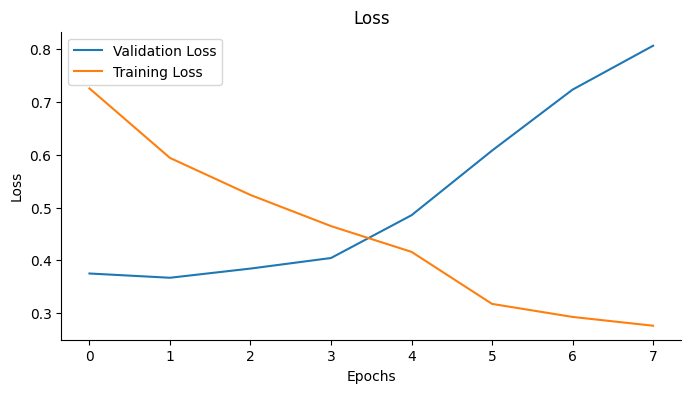

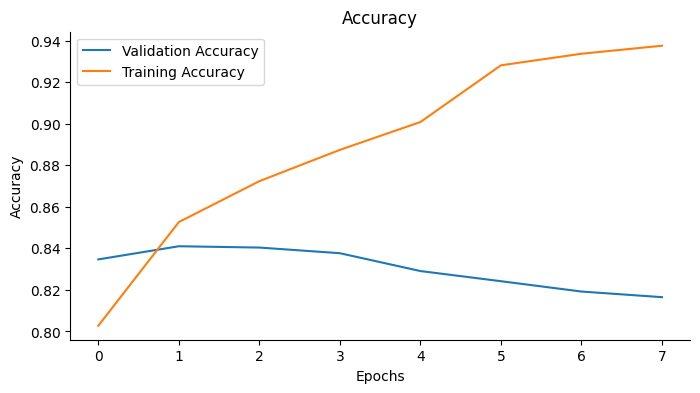

In [10]:
results = read_csv(os.path.join("eval", "sentiment_analysis.log"), index_col=0)
print(results)

# Plot both val_loss and loss
results[["val_loss", "loss"]].plot(kind="line", figsize=(8, 4), title="Loss")
pyplot.gca().spines[["top", "right"]].set_visible(False)

# Set labels and legend
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.legend(["Validation Loss", "Training Loss"])

# Show plot
pyplot.show()

# Plot accuracy and val_accuracy
results[["val_accuracy", "accuracy"]].plot(
    kind="line", figsize=(8, 4), title="Accuracy"
)
pyplot.gca().spines[["top", "right"]].set_visible(False)

# Set labels and legend
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy")
pyplot.legend(["Validation Accuracy", "Training Accuracy"])

# Show plot
pyplot.show()